# Аугментация датасета ВТБ FAQ

В этом ноутбуке мы будем:
1. Анализировать распределение вопросов по категориям
2. Определять где не хватает примеров
3. Генерировать синтетические вопросы для недостающих категорий
4. Создавать итоговый датасет с бинарной меткой (оригинальный/сгенерированный)


In [1]:
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

True

In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Загрузка и предварительный анализ данных


In [28]:
data_path = Path('../data/smart_support_vtb_belarus_faq_final.csv')
# df = pd.read_csv(data_path)
df = df_augmented

print(f"Размер датасета: {df.shape}")
print(f"\nКолонки: {list(df.columns)}")
print(f"\nПервые строки:")
df.head()


Размер датасета: (233, 6)

Колонки: ['Основная категория', 'Подкатегория', 'Пример вопроса', 'Целевая аудитория', 'Шаблонный ответ', 
'is_original']

Первые строки:

,Основная категория,Подкатегория,Пример вопроса,Целевая аудитория,Шаблонный ответ,is_original
0,Новые клиенты,Регистрация и онбординг,Как стать клиентом банка онлайн?,новые клиенты,Стать клиентом ВТБ (Беларусь) можно онлайн через сайт vtb.by или мобильное приложение VTB mBank. Для регистрации потребуется паспорт и номер телефона. После регистрации через МСИ (Межбанковскую систему идентификации) вы получите доступ к банковским услугам.,True
1,Новые клиенты,Регистрация и онбординг,Регистрация через МСИ (Межбанковская система идентификации),новые клиенты,"МСИ позволяет пройти идентификацию онлайн, используя данные других банков, где вы уже являетесь клиентом. Это упрощает процедуру регистрации и делает её быстрой и безопасной.",True
2,Новые клиенты,Регистрация и онбординг,Документы для регистрации нового клиента,новые клиенты,Для регистрации в качестве нового клиента необходим паспорт гражданина Республики Беларусь и контактный номер мобильного телефона для получения SMS-подтверждений.,True
3,Новые клиенты,Первые шаги,Первый вход в Интернет-банк,новые клиенты,После регистрации вы получите логин и пароль для входа в систему Интернет-банк. При первом входе рекомендуется изменить временный пароль на постоянный и настроить дополнительные параметры безопасности.,True
4,Новые клиенты,Первые шаги,Как скачать и настроить мобильное приложение?,новые клиенты,Мобильное приложение VTB mBank можно скачать в App Store для iOS или Google Play для Android. После установки войдите с логином и паролем от Интернет-банка и пройдите первоначальную настройку.,True


In [ ]:
df_clean = df[['Основная категория', 'Подкатегория', 'Пример вопроса', 'Целевая аудитория', 'Шаблонный ответ']].copy()

df_clean = df_clean.dropna(subset=['Пример вопроса', 'Шаблонный ответ'])

df_clean['Стиль вопроса'] = None
df_clean['is_original'] = True

print(f"Очищенный датасет: {df_clean.shape}")
df_clean.head()


Очищенный датасет: (233, 6)

,Основная категория,Подкатегория,Пример вопроса,Целевая аудитория,Шаблонный ответ,is_original
0,Новые клиенты,Регистрация и онбординг,Как стать клиентом банка онлайн?,новые клиенты,Стать клиентом ВТБ (Беларусь) можно онлайн через сайт vtb.by или мобильное приложение VTB mBank. Для регистрации потребуется паспорт и номер телефона. После регистрации через МСИ (Межбанковскую систему идентификации) вы получите доступ к банковским услугам.,True
1,Новые клиенты,Регистрация и онбординг,Регистрация через МСИ (Межбанковская система идентификации),новые клиенты,"МСИ позволяет пройти идентификацию онлайн, используя данные других банков, где вы уже являетесь клиентом. Это упрощает процедуру регистрации и делает её быстрой и безопасной.",True
2,Новые клиенты,Регистрация и онбординг,Документы для регистрации нового клиента,новые клиенты,Для регистрации в качестве нового клиента необходим паспорт гражданина Республики Беларусь и контактный номер мобильного телефона для получения SMS-подтверждений.,True
3,Новые клиенты,Первые шаги,Первый вход в Интернет-банк,новые клиенты,После регистрации вы получите логин и пароль для входа в систему Интернет-банк. При первом входе рекомендуется изменить временный пароль на постоянный и настроить дополнительные параметры безопасности.,True
4,Новые клиенты,Первые шаги,Как скачать и настроить мобильное приложение?,новые клиенты,Мобильное приложение VTB mBank можно скачать в App Store для iOS или Google Play для Android. После установки войдите с логином и паролем от Интернет-банка и пройдите первоначальную настройку.,True


## 2. Анализ распределения по категориям


Распределение по основным категориям:

Продукты - Карты: 64

Частные клиенты: 62

Продукты - Кредиты: 46

Продукты - Вклады: 45

Новые клиенты: 10

Техническая поддержка: 6

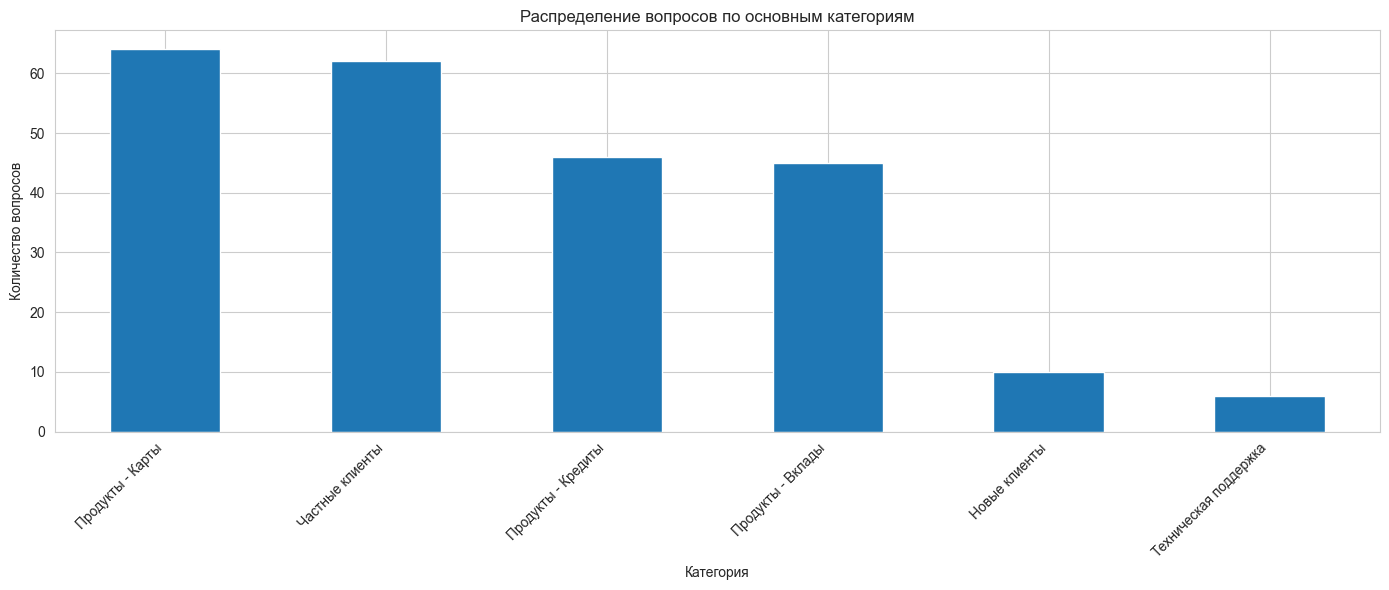

In [31]:
category_counts = df_clean['Основная категория'].value_counts()

print("Распределение по основным категориям:")
for cat, count in category_counts.items():
    print(f"  {cat}: {count}")

plt.figure(figsize=(14, 6))
category_counts.plot(kind='bar')
plt.title('Распределение вопросов по основным категориям')
plt.xlabel('Категория')
plt.ylabel('Количество вопросов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [32]:
subcategory_counts = df_clean.groupby(['Основная категория', 'Подкатегория']).size().reset_index(name='count')
subcategory_counts = subcategory_counts.sort_values('count', ascending=False)

print("\nРаспределение по подкатегориям (топ 20):")
print(subcategory_counts.head(20))

subcategory_counts_bottom = subcategory_counts[subcategory_counts['count'] <= 3]
print(f"\nПодкатегорий с ≤ 3 примерами: {len(subcategory_counts_bottom)}")
print(subcategory_counts_bottom)


Распределение по подкатегориям (топ 20):

Основная категория                      Подкатегория  count
33        Частные клиенты                           Кредиты     22
31        Частные клиенты               Банковские карточки     19
32        Частные клиенты                 Вклады и депозиты     15
17       Продукты - Карты        Карты рассрочки - ЧЕРЕПАХА      8
12       Продукты - Карты            Дебетовые карты - MORE      8
18       Продукты - Карты         Кредитные карты - PLAT/ON      7
16       Продукты - Карты          Карты рассрочки - КСТАТИ      7
15       Продукты - Карты          Дебетовые карты - Форсаж      7
30  Техническая поддержка                Проблемы и решения      6
26     Продукты - Кредиты  Потребительские - На всё про всё      6
20       Продукты - Карты    Кредитные карты - Портмоне 2.0      6
14       Продукты - Карты      Дебетовые карты - Комплимент      6
34        Частные клиенты                    Онлайн-сервисы      6
13       Продукты - Карты       Дебетовые карты - Signature      5
11       Продукты - Карты        Дебетовые карты - Infinite      5
2       Продукты - Вклады                    Валютные - CNY      5
3       Продукты - Вклады                    Валютные - EUR      5
4       Продукты - Вклады                    Валютные - RUB      5
5       Продукты - Вклады                    Валютные - USD      5
29     Продукты - Кредиты      Экспресс-кредиты - На роднае      5

Подкатегорий с ≤ 3 примерами: 0

Empty DataFrame
Columns: [Основная категория, Подкатегория, count]
Index: []

In [33]:
audience_counts = df_clean['Целевая аудитория'].value_counts()
print("\nРаспределение по целевой аудитории:")
print(audience_counts)


Распределение по целевой аудитории:

Целевая аудитория
новые клиенты    179
все клиенты       54
Name: count, dtype: int64

## 3. Определение категорий для аугментации


In [35]:
MIN_SAMPLES_PER_SUBCATEGORY = 15

categories_need_augmentation = subcategory_counts[subcategory_counts['count'] < MIN_SAMPLES_PER_SUBCATEGORY].copy()
categories_need_augmentation['samples_to_generate'] = MIN_SAMPLES_PER_SUBCATEGORY - categories_need_augmentation['count']

print(f"Категорий требующих аугментации: {len(categories_need_augmentation)}")
print(f"Всего нужно сгенерировать вопросов: {categories_need_augmentation['samples_to_generate'].sum()}")
print("\nДетали:")
print(categories_need_augmentation)


Категорий требующих аугментации: 32

Всего нужно сгенерировать вопросов: 303

Детали:

Основная категория                              Подкатегория  count  \
17       Продукты - Карты                Карты рассрочки - ЧЕРЕПАХА      8   
12       Продукты - Карты                    Дебетовые карты - MORE      8   
18       Продукты - Карты                 Кредитные карты - PLAT/ON      7   
16       Продукты - Карты                  Карты рассрочки - КСТАТИ      7   
15       Продукты - Карты                  Дебетовые карты - Форсаж      7   
30  Техническая поддержка                        Проблемы и решения      6   
26     Продукты - Кредиты          Потребительские - На всё про всё      6   
20       Продукты - Карты            Кредитные карты - Портмоне 2.0      6   
14       Продукты - Карты              Дебетовые карты - Комплимент      6   
34        Частные клиенты                            Онлайн-сервисы      6   
13       Продукты - Карты               Дебетовые карты - Signature      5   
11       Продукты - Карты                Дебетовые карты - Infinite      5   
2       Продукты - Вклады                            Валютные - CNY      5   
3       Продукты - Вклады                            Валютные - EUR      5   
4       Продукты - Вклады                            Валютные - RUB      5   
5       Продукты - Вклады                            Валютные - USD      5   
29     Продукты - Кредиты              Экспресс-кредиты - На роднае      5   
28     Продукты - Кредиты  Экспресс-кредиты - В магазинах-партнерах      5   
27     Продукты - Кредиты                   Потребительские - Старт      5   
6       Продукты - Вклады                   Рублевые - Великий путь      5   
25     Продукты - Кредиты           Потребительские - Легко платить      5   
24     Продукты - Кредиты         Потребительские - Дальше - меньше      5   
23     Продукты - Кредиты   Потребительские - Всё только начинается      5   
22     Продукты - Кредиты           Онлайн кредиты - Проще в онлайн      5   
21     Продукты - Кредиты       Автокредиты - Автокредит без залога      5   
7       Продукты - Вклады                    Рублевые - Мои условия      5   
19       Продукты - Карты                Кредитные карты - Отличник      5   
8       Продукты - Вклады             Рублевые - Мои условия онлайн      5   
1           Новые клиенты                   Регистрация и онбординг      5   
9       Продукты - Вклады           Рублевые - Подушка безопасности      5   
10      Продукты - Вклады                      Рублевые - СуперСемь      5   
0           Новые клиенты                               Первые шаги      5   

    samples_to_generate  
17                    7  
12                    7  
18                    8  
16                    8  
15                    8  
30                    9  
26                    9  
20                    9  
14                    9  
34                    9  
13                   10  
11                   10  
2                    10  
3                    10  
4                    10  
5                    10  
29                   10  
28                   10  
27                   10  
6                    10  
25                   10  
24                   10  
23                   10  
22                   10  
21                   10  
7                    10  
19                   10  
8                    10  
1                    10  
9                    10  
10                   10  
0                    10

## 4. Генерация синтетических вопросов


In [58]:
from pydantic import BaseModel, Field
from typing import Literal
import openai
import instructor
from asyncio import Semaphore
from tqdm.asyncio import tqdm_asyncio
import asyncio
from tenacity import retry, stop_after_attempt, wait_fixed
from dotenv import load_dotenv
import os

load_dotenv()

class SyntheticQuestion(BaseModel):
    question: str = Field(description="Сгенерированный вопрос на русском языке")
    style: Literal["Жаргонный", "Технический жаргон", "Сленговый", "Официальный"] = Field(
        description="Стиль вопроса"
    )
    reasoning: str = Field(description="Обоснование почему этот вопрос релевантен и почему выбран такой стиль")

class QuestionBatch(BaseModel):
    questions: list[SyntheticQuestion] = Field(description="Список сгенерированных вопросов")


In [ ]:
client = instructor.from_openai(openai.AsyncOpenAI())

    # "Используйте другие формулировки и синонимы",
    # "Добавьте конкретный контекст или ситуацию",
    # "Сделайте вопрос более детальным с уточнениями",
    # "Используйте разговорный стиль",
    # "Сформулируйте вопрос от лица клиента с конкретной проблемой"


constraints = [
    "Используй разговорный стиль с сокращениями (типа 'не понял как', 'чё делать', 'а если')",
    "Добавь эмоциональную окраску: раздражение или недовольство (например 'опять', 'уже замучился', 'почему всегда')",
    "Используй неуверенность или растерянность ('не пойму', 'запутался', 'не могу разобраться')",
    "Добавь срочность или беспокойство ('срочно нужно', 'что делать!', 'помогите')",
    "Используй неформальный сленг и упрощенные фразы ('бабки', 'кэш', 'инет', 'чек', 'терик')",
    "Сформулируй от лица пожилого человека с непониманием технологий",
    "Добавь разговорные конструкции ('ну и как мне', 'а можно так', 'типа если я')",
    "Используй вопрос с предысторией или конкретной бытовой ситуацией",
    "Добавь удивление или недоумение ('Серьезно?!', 'И что теперь?', 'не может быть')",
    "Используй молодежный сленг и упрощения ('прога', 'апп', 'забанили', 'зачислить')",
    "Сформулируй максимально коротко и неполными предложениями",
    "Добавь благодарность или вежливость наперед ('подскажите пожалуйста', 'будьте добры')"
]

@retry(stop=stop_after_attempt(3), wait=wait_fixed(5))
async def generate_questions_for_category(
    category: str,
    subcategory: str,
    existing_questions: list[str],
    template_answer: str,
    num_questions: int,
    sem: Semaphore
) -> list[SyntheticQuestion]:
    async with sem:
        import random
        selected_constraints = random.sample(constraints, min(3, len(constraints)))
        
        coro = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": """Ты помощник, который генерирует РЕАЛИСТИЧНЫЕ вопросы для FAQ банка ВТБ (Беларусь). 
Вопросы должны звучать так, как РЕАЛЬНО спрашивают люди в техподдержку - с эмоциями, сленгом, неточностями.
НЕ используй официальный банковский язык. Пиши как обычные люди говорят в жизни."""
                },
                {
                    "role": "user",
                    "content": f"""
Сгенерируй {num_questions} ЕСТЕСТВЕННЫХ вопроса для категории:

Категория: {category}
Подкатегория: {subcategory}

Шаблонный ответ (для контекста):
{template_answer[:300]}...

Примеры уже существующих вопросов (НЕ копируй их!):
{chr(10).join(f'- {q}' for q in existing_questions[:3])}

ВАЖНЫЕ ПРАВИЛА:
- Вопросы должны звучать ЕСТЕСТВЕННО, как говорят люди в жизни
- Используй разговорный язык, сленг, эмоции
- Формулировки должны быть МЕНЕЕ очевидными, непрямыми
- Добавляй контекст из жизни ("купил квартиру", "потерял телефон", "еду в отпуск")
- Можно использовать неполные предложения, разговорные обороты
- Применяй эти стили: {', '.join(selected_constraints)}
- Длина: 1-2 предложения или даже отрывистые фразы
- Вопросы ОБЯЗАТЕЛЬНО должны относиться к теме и ответу

СТИЛИ ВОПРОСОВ (определи для каждого вопроса):
- "Жаргонный" - использует банковский/финансовый жаргон обычных людей ("бабки", "кэш", "налик", "безнал", "пластик")
- "Технический жаргон" - использует IT и технические термины ("апп", "прога", "логин", "пуш", "смс-ка", "юзать")
- "Сленговый" - молодежный или разговорный сленг, эмоции ("чё", "типа", "забанили", "облом", "капец")
- "Официальный" - нейтральный, вежливый тон без жаргона и сленга ("подскажите пожалуйста", "как можно", "не могли бы вы")

ПРИМЕРЫ по стилям:
Жаргонный: "А где мои бабки? Переводил налик на карту вчера"
Технический жаргон: "Апп вылетает когда логинюсь через биометрию, что делать?"
Сленговый: "Чё за фигня, карта не проходит опять, замучили уже!"
Официальный: "Подскажите пожалуйста, как можно восстановить доступ к личному кабинету?"

Создавай РАЗНООБРАЗИЕ - используй разные стили!
"""
                }
            ],
            response_model=QuestionBatch,
        )
        
        resp = await asyncio.wait_for(coro, timeout=60)
        return resp.questions


In [ ]:
test_cat = df_clean[df_clean['Подкатегория'].notna()].iloc[0]

print(f"Категория: {test_cat['Основная категория']}")
print(f"Подкатегория: {test_cat['Подкатегория']}")
print(f"Пример вопроса: {test_cat['Пример вопроса']}")
print(f"\nОтвет: {test_cat['Шаблонный ответ'][:200]}...")

sem = Semaphore(1)
test_questions = await generate_questions_for_category(
    category=test_cat['Основная категория'],
    subcategory=test_cat['Подкатегория'],
    existing_questions=[test_cat['Пример вопроса']],
    template_answer=test_cat['Шаблонный ответ'],
    num_questions=3,
    sem=sem
)

print("\nСгенерированные вопросы:")
for i, q in enumerate(test_questions, 1):
    print(f"\n{i}. {q.question}")
    print(f"   Стиль: {q.style}")
    print(f"   Обоснование: {q.reasoning}")


Категория: Новые клиенты

Подкатегория: Регистрация и онбординг

Пример вопроса: Как стать клиентом банка онлайн?

Ответ: Стать клиентом ВТБ (Беларусь) можно онлайн через сайт vtb.by или мобильное приложение VTB mBank. Для 
регистрации потребуется паспорт и номер телефона. После регистрации через МСИ (Межбанковскую систем...

Сгенерированные вопросы:

1. Ну и как мне зарегистрироваться в вашем банке, если я только заменил паспорт и он ещё не готов?

Обоснование: Возникает ситуация, когда у клиента есть паспорт, но он ждёт его замены, и стоит вопрос о 
регистрации.

2. Что делать, если я в отпуске, а нужно срочно открыть счёт?

Обоснование: Клиенты могут оказаться в ситуации, когда они не могут зарегистрироваться из-за нахождения за 
границей.

3. Как я могу стать вашим клиентом, если потерял телефон и теперь не могу получить код подтверждения?

Обоснование: Этот вопрос касается проблемы с доступом к телефонным данным для регистрации.

### Генерация для всех недостающих категорий


In [ ]:
async def augment_dataset(df_original: pd.DataFrame, categories_to_augment: pd.DataFrame, max_concurrent: int = 5):
    sem = Semaphore(max_concurrent)
    tasks = []
    
    for _, row in categories_to_augment.iterrows():
        cat = row['Основная категория']
        subcat = row['Подкатегория']
        num_to_gen = row['samples_to_generate']
        
        existing_data = df_original[
            (df_original['Основная категория'] == cat) & 
            (df_original['Подкатегория'] == subcat)
        ]
        
        if len(existing_data) == 0:
            continue
            
        existing_questions = existing_data['Пример вопроса'].tolist()
        template_answer = existing_data['Шаблонный ответ'].iloc[0]
        target_audience = existing_data['Целевая аудитория'].iloc[0]
        
        task = {
            'category': cat,
            'subcategory': subcat,
            'existing_questions': existing_questions,
            'template_answer': template_answer,
            'target_audience': target_audience,
            'num_questions': num_to_gen
        }
        tasks.append(task)
    
    async def process_task(task):
        questions = await generate_questions_for_category(
            category=task['category'],
            subcategory=task['subcategory'],
            existing_questions=task['existing_questions'],
            template_answer=task['template_answer'],
            num_questions=task['num_questions'],
            sem=sem
        )
        
        return [
            {
                'Основная категория': task['category'],
                'Подкатегория': task['subcategory'],
                'Пример вопроса': q.question,
                'Стиль вопроса': q.style,
                'Целевая аудитория': task['target_audience'],
                'Шаблонный ответ': task['template_answer'],
                'is_original': False
            }
            for q in questions
        ]
    
    results = []
    for task_result in tqdm_asyncio.as_completed(
        [process_task(task) for task in tasks],
        total=len(tasks),
        desc="Генерация вопросов"
    ):
        result = await task_result
        results.extend(result)
    
    return pd.DataFrame(results)


In [50]:
df_synthetic = await augment_dataset(df_clean, categories_need_augmentation, max_concurrent=5)

print(f"\nСгенерировано синтетических вопросов: {len(df_synthetic)}")
print(f"\nПримеры:")
print(df_synthetic.head(10))


Генерация вопросов: 100%|██████████| 32/32 [01:19<00:00,  2.48s/it]


Сгенерировано синтетических вопросов: 294

Примеры:

Основная категория                    Подкатегория  \
0    Продукты - Карты  Кредитные карты - Портмоне 2.0   
1    Продукты - Карты  Кредитные карты - Портмоне 2.0   
2    Продукты - Карты  Кредитные карты - Портмоне 2.0   
3    Продукты - Карты  Кредитные карты - Портмоне 2.0   
4    Продукты - Карты  Кредитные карты - Портмоне 2.0   
5    Продукты - Карты  Кредитные карты - Портмоне 2.0   
6    Продукты - Карты  Кредитные карты - Портмоне 2.0   
7    Продукты - Карты  Кредитные карты - Портмоне 2.0   
8    Продукты - Карты  Кредитные карты - Портмоне 2.0   
9  Продукты - Кредиты         Потребительские - Старт   

                                                                             Пример вопроса  \
0                       Что-то не так с этой картой Портмоне, может её блокировать или как?   
1                                             Если я её потерял, как быстро получить новую?   
2                                         А реально ли сделать карту Портмоне за один день?   
3                                      Могу я контролировать расходы по карте в приложении?   
4                           Как вообще пользоваться этой картой, там награды какие-то есть?   
5                           Если купил что-то не то, можно вернуть деньги обратно на карту?   
6                           Нужно ли сначала открывать счёт, чтобы оформить карту Портмоне?   
7                       Что делать если в магазине карту не принимают, я ж уже всё оформил!   
8              А можно ли пользоваться картой Портмоне за границей, если в отпуск сваливаю?   
9  Слушайте, я тут квартиру купил, и что-то не пойму, как мне этот кредит "Старт" оформить?   

  Целевая аудитория  \
0     новые клиенты   
1     новые клиенты   
2     новые клиенты   
3     новые клиенты   
4     новые клиенты   
5     новые клиенты   
6     новые клиенты   
7     новые клиенты   
8     новые клиенты   
9     новые клиенты   

                                                                                                   Шаблонный ответ 
\
0  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
1  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
2  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
3  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
4  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
5  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
6  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
7  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
8  Кредитную карту Портмоне 2.0 можно оформить в любом отделении банка. Используется карточка мгновенного выпуска. 
9          Сумма кредита 'Старт' определяется индивидуально в зависимости от доходов и платежеспособности клиента. 

   is_original  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6        False  
7        False  
8        False  
9        False

## 5. Объединение оригинальных и синтетических данных


In [ ]:
df_augmented = pd.concat([df_clean, df_synthetic], ignore_index=True)

print(f"Итоговый размер датасета: {len(df_augmented)}")
print(f"Оригинальных вопросов: {df_augmented['is_original'].sum()}")
print(f"Синтетических вопросов: {(~df_augmented['is_original']).sum()}")

print("\nРаспределение по стилям вопросов:")
style_counts = df_augmented['Стиль вопроса'].value_counts(dropna=False)
for style, count in style_counts.items():
    percentage = count / len(df_augmented) * 100
    print(f"  {style if style else 'Не указан (оригинальные)'}: {count} ({percentage:.1f}%)")

augmented_subcategory_counts = df_augmented.groupby(['Основная категория', 'Подкатегория']).size().reset_index(name='count')
augmented_subcategory_counts = augmented_subcategory_counts.sort_values('count')

print("\nРаспределение после аугментации (минимальные):")
print(augmented_subcategory_counts.head(10))


Итоговый размер датасета: 527

Оригинальных вопросов: 233

Синтетических вопросов: 294

Распределение после аугментации (минимальные):

Основная категория                              Подкатегория  count
29     Продукты - Кредиты              Экспресс-кредиты - На роднае      6
0           Новые клиенты                               Первые шаги     15
32        Частные клиенты                         Вклады и депозиты     15
30  Техническая поддержка                        Проблемы и решения     15
28     Продукты - Кредиты  Экспресс-кредиты - В магазинах-партнерах     15
27     Продукты - Кредиты                   Потребительские - Старт     15
26     Продукты - Кредиты          Потребительские - На всё про всё     15
25     Продукты - Кредиты           Потребительские - Легко платить     15
24     Продукты - Кредиты         Потребительские - Дальше - меньше     15
23     Продукты - Кредиты   Потребительские - Всё только начинается     15

## 6. Сохранение результатов


In [52]:
output_path = Path('../data/knowledge_base_augmented2.csv')
df_augmented.to_csv(output_path, index=False, encoding='utf-8')

print(f"Аугментированный датасет сохранен в: {output_path}")
print(f"\nСтатистика:")
print(f"- Всего записей: {len(df_augmented)}")
print(f"- Оригинальных: {df_augmented['is_original'].sum()}")
print(f"- Синтетических: {(~df_augmented['is_original']).sum()}")
print(f"- Уникальных категорий: {df_augmented['Основная категория'].nunique()}")
print(f"- Уникальных подкатегорий: {df_augmented['Подкатегория'].nunique()}")


Аугментированный датасет сохранен в: ../data/knowledge_base_augmented2.csv

Статистика:

- Всего записей: 527

- Оригинальных: 233

- Синтетических: 294

- Уникальных категорий: 6

- Уникальных подкатегорий: 35

In [53]:
df_augmented.loc[df_augmented.index > 201, 'is_original'] = False

In [55]:
output_path = Path('../data/knowledge_base_augmented3.csv')
df_augmented.to_csv(output_path, index=False, encoding='utf-8')

print(f"Аугментированный датасет сохранен в: {output_path}")
print(f"\nСтатистика:")
print(f"- Всего записей: {len(df_augmented)}")
print(f"- Оригинальных: {df_augmented['is_original'].sum()}")
print(f"- Синтетических: {(~df_augmented['is_original']).sum()}")
print(f"- Уникальных категорий: {df_augmented['Основная категория'].nunique()}")
print(f"- Уникальных подкатегорий: {df_augmented['Подкатегория'].nunique()}")

Аугментированный датасет сохранен в: ../data/knowledge_base_augmented3.csv

Статистика:

- Всего записей: 527

- Оригинальных: 202

- Синтетических: 325

- Уникальных категорий: 6

- Уникальных подкатегорий: 35

## 7. Визуализация результатов


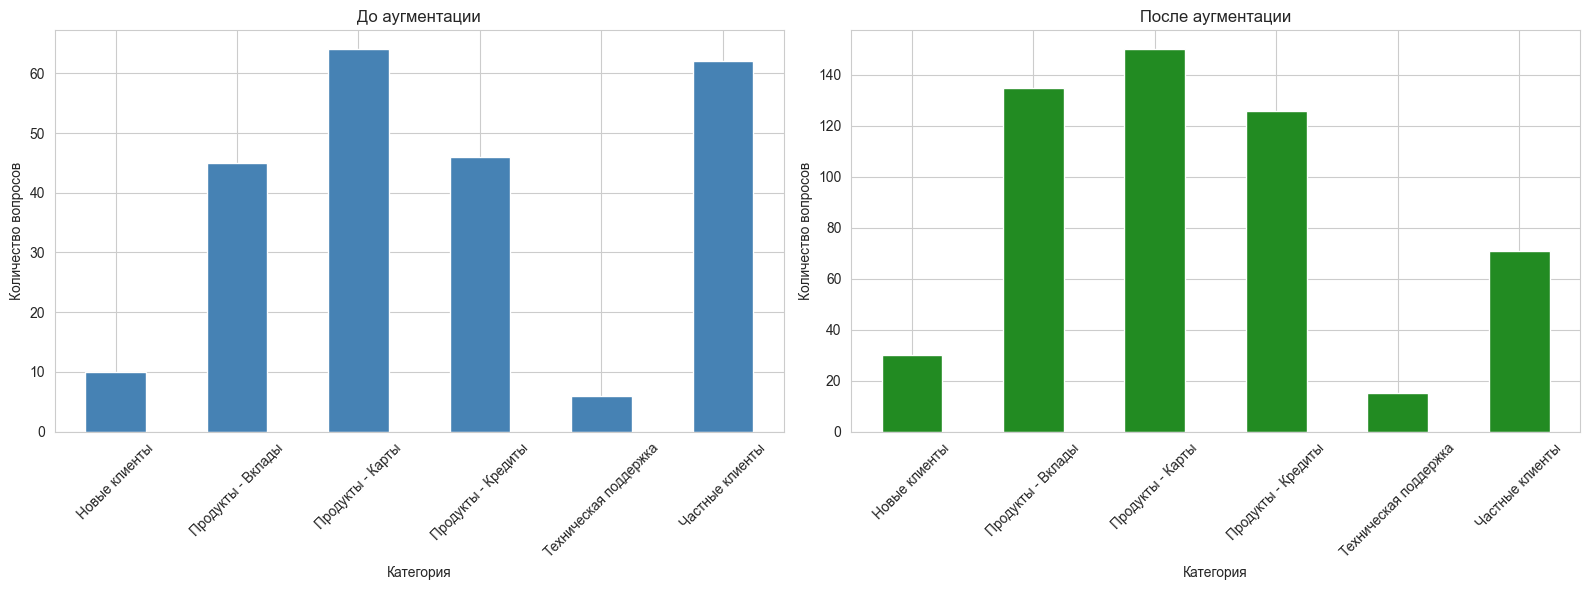

Визуализация сохранена в: ../data/augmentation_comparison.png

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_clean.groupby('Основная категория').size().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('До аугментации')
axes[0].set_xlabel('Категория')
axes[0].set_ylabel('Количество вопросов')
axes[0].tick_params(axis='x', rotation=45)

df_augmented.groupby('Основная категория').size().plot(kind='bar', ax=axes[1], color='forestgreen')
axes[1].set_title('После аугментации')
axes[1].set_xlabel('Категория')
axes[1].set_ylabel('Количество вопросов')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/augmentation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Визуализация сохранена в: ../data/augmentation_comparison.png")


In [ ]:
style_counts = df_augmented['Стиль вопроса'].value_counts(dropna=False)
style_counts.index = style_counts.index.fillna('Не указан (оригинальные)')

plt.figure(figsize=(10, 6))
style_counts.plot(kind='bar', color='coral')
plt.title('Распределение синтетических вопросов по стилям')
plt.xlabel('Стиль вопроса')
plt.ylabel('Количество вопросов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../data/style_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Визуализация сохранена в: ../data/style_distribution.png")


### Примеры вопросов по стилям


In [ ]:
synthetic_only = df_augmented[df_augmented['is_original'] == False]

styles = ["Жаргонный", "Технический жаргон", "Сленговый", "Официальный"]

for style in styles:
    style_examples = synthetic_only[synthetic_only['Стиль вопроса'] == style]
    if len(style_examples) > 0:
        print(f"\n{'='*80}")
        print(f"Стиль: {style} ({len(style_examples)} вопросов)")
        print(f"{'='*80}")
        
        for i, (_, row) in enumerate(style_examples.head(5).iterrows(), 1):
            print(f"\n{i}. {row['Пример вопроса']}")
            print(f"   Категория: {row['Основная категория']} / {row['Подкатегория']}")


## 8. Классификация стилей для существующего датасета

Загружаем существующий датасет и добавляем классификацию стилей для всех вопросов


In [56]:
existing_dataset_path = Path('../data/knowledge_base_augmented3.csv')
df_existing = pd.read_csv(existing_dataset_path)

print(f"Загружен датасет: {len(df_existing)} записей")
print(f"Колонки: {list(df_existing.columns)}")
print(f"\nПервые строки:")
df_existing.head()


Загружен датасет: 527 записей

Колонки: ['Основная категория', 'Подкатегория', 'Пример вопроса', 'Целевая аудитория', 'Шаблонный ответ', 
'is_original']

Первые строки:

,Основная категория,Подкатегория,Пример вопроса,Целевая аудитория,Шаблонный ответ,is_original
0,Новые клиенты,Регистрация и онбординг,Как стать клиентом банка онлайн?,новые клиенты,Стать клиентом ВТБ (Беларусь) можно онлайн через сайт vtb.by или мобильное приложение VTB mBank. Для регистрации потребуется паспорт и номер телефона. После регистрации через МСИ (Межбанковскую систему идентификации) вы получите доступ к банковским услугам.,True
1,Новые клиенты,Регистрация и онбординг,Регистрация через МСИ (Межбанковская система идентификации),новые клиенты,"МСИ позволяет пройти идентификацию онлайн, используя данные других банков, где вы уже являетесь клиентом. Это упрощает процедуру регистрации и делает её быстрой и безопасной.",True
2,Новые клиенты,Регистрация и онбординг,Документы для регистрации нового клиента,новые клиенты,Для регистрации в качестве нового клиента необходим паспорт гражданина Республики Беларусь и контактный номер мобильного телефона для получения SMS-подтверждений.,True
3,Новые клиенты,Первые шаги,Первый вход в Интернет-банк,новые клиенты,После регистрации вы получите логин и пароль для входа в систему Интернет-банк. При первом входе рекомендуется изменить временный пароль на постоянный и настроить дополнительные параметры безопасности.,True
4,Новые клиенты,Первые шаги,Как скачать и настроить мобильное приложение?,новые клиенты,Мобильное приложение VTB mBank можно скачать в App Store для iOS или Google Play для Android. После установки войдите с логином и паролем от Интернет-банка и пройдите первоначальную настройку.,True


In [59]:
class QuestionStyle(BaseModel):
    style: Literal["Жаргонный", "Технический жаргон", "Сленговый", "Официальный"] = Field(
        description="Стиль вопроса"
    )
    reasoning: str = Field(description="Краткое обоснование выбора стиля")

@retry(stop=stop_after_attempt(3), wait=wait_fixed(5))
async def classify_question_style(question: str, sem: Semaphore) -> QuestionStyle:
    async with sem:
        coro = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": """Ты эксперт по классификации стилей вопросов для банковской техподдержки.
Твоя задача - определить стиль вопроса на русском языке."""
                },
                {
                    "role": "user",
                    "content": f"""
Определи стиль следующего вопроса:

"{question}"

СТИЛИ:
- "Жаргонный" - использует банковский/финансовый жаргон обычных людей ("бабки", "кэш", "налик", "безнал", "пластик")
- "Технический жаргон" - использует IT и технические термины ("апп", "прога", "логин", "пуш", "смс-ка", "юзать")
- "Сленговый" - молодежный или разговорный сленг, эмоции ("чё", "типа", "забанили", "облом", "капец")
- "Официальный" - нейтральный, вежливый тон без жаргона и сленга ("подскажите пожалуйста", "как можно", "не могли бы вы")

Выбери ОДИН наиболее подходящий стиль.
"""
                }
            ],
            response_model=QuestionStyle,
        )
        
        resp = await asyncio.wait_for(coro, timeout=30)
        return resp


In [60]:
async def classify_all_questions(df: pd.DataFrame, max_concurrent: int = 10):
    sem = Semaphore(max_concurrent)
    
    async def classify_row(idx, question):
        try:
            result = await classify_question_style(question, sem)
            return idx, result.style
        except Exception as e:
            print(f"Ошибка при классификации вопроса {idx}: {e}")
            return idx, "Официальный"
    
    tasks = [
        classify_row(idx, row['Пример вопроса'])
        for idx, row in df.iterrows()
    ]
    
    results = {}
    for task_result in tqdm_asyncio.as_completed(tasks, total=len(tasks), desc="Классификация вопросов"):
        idx, style = await task_result
        results[idx] = style
    
    return results


### Тестовая классификация


In [61]:
test_df = df_existing.head(10).copy()

test_results = await classify_all_questions(test_df, max_concurrent=5)

test_df['Стиль вопроса'] = test_df.index.map(test_results)

print("\nРезультаты классификации:")
for idx, row in test_df.iterrows():
    print(f"\nВопрос: {row['Пример вопроса']}")
    print(f"Стиль: {row['Стиль вопроса']}")


Классификация вопросов:   0%|          | 0/10 [00:00<?, ?it/s]

Ошибка при классификации вопроса 0: RetryError[<Future at 0x164cb1d10 state=finished raised 
InstructorRetryException>]

Классификация вопросов:  10%|█         | 1/10 [00:49<07:25, 49.47s/it]

Ошибка при классификации вопроса 4: RetryError[<Future at 0x164b71150 state=finished raised 
InstructorRetryException>]

Ошибка при классификации вопроса 6: RetryError[<Future at 0x164c73fd0 state=finished raised 
InstructorRetryException>]

Ошибка при классификации вопроса 8: RetryError[<Future at 0x164cf45d0 state=finished raised 
InstructorRetryException>]

Ошибка при классификации вопроса 2: RetryError[<Future at 0x164cf6290 state=finished raised 
InstructorRetryException>]

Ошибка при классификации вопроса 9: RetryError[<Future at 0x164d7ee10 state=finished raised 
InstructorRetryException>]

Классификация вопросов:  60%|██████    | 6/10 [00:54<00:27,  6.95s/it]

Ошибка при классификации вопроса 3: RetryError[<Future at 0x164d88790 state=finished raised 
InstructorRetryException>]

Ошибка при классификации вопроса 5: RetryError[<Future at 0x164d88e50 state=finished raised 
InstructorRetryException>]

Ошибка при классификации вопроса 7: RetryError[<Future at 0x164d6a310 state=finished raised 
InstructorRetryException>]

Ошибка при классификации вопроса 1: RetryError[<Future at 0x164d7f950 state=finished raised 
InstructorRetryException>]

Классификация вопросов: 100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


Результаты классификации:

Вопрос: Как стать клиентом банка онлайн?

Стиль: Официальный

Вопрос: Регистрация через МСИ (Межбанковская система идентификации)

Стиль: Официальный

Вопрос: Документы для регистрации нового клиента

Стиль: Официальный

Вопрос: Первый вход в Интернет-банк

Стиль: Официальный

Вопрос: Как скачать и настроить мобильное приложение?

Стиль: Официальный

Вопрос: Не могу войти в Интернет-банк

Стиль: Официальный

Вопрос: Я нахожусь за пределами Республики Беларусь. Как я могу связаться с работниками банка, за исключением 
телефонного звонка?

Стиль: Официальный

Вопрос: Забыл пароль от мобильного приложения

Стиль: Официальный

Вопрос: Карта заблокирована - что делать?

Стиль: Официальный

Вопрос: Могу ли я оставить обращение, не обращаясь лично в офис банка?

Стиль: Официальный

### Классификация всего датасета

ВАЖНО: Это займет некоторое время в зависимости от размера датасета


In [62]:
print(f"Начинаем классификацию {len(df_existing)} вопросов...")
print("Это займет примерно", len(df_existing) // 10, "минут")

all_results = await classify_all_questions(df_existing, max_concurrent=10)

df_existing['Стиль вопроса'] = df_existing.index.map(all_results)

print("\n✓ Классификация завершена!")
print(f"\nРаспределение по стилям:")
style_dist = df_existing['Стиль вопроса'].value_counts()
for style, count in style_dist.items():
    percentage = count / len(df_existing) * 100
    print(f"  {style}: {count} ({percentage:.1f}%)")


Начинаем классификацию 527 вопросов...

Это займет примерно 52 минут

Классификация вопросов: 100%|██████████| 527/527 [01:48<00:00,  4.84it/s]


✓ Классификация завершена!

Распределение по стилям:

Официальный: 275 (52.2%)

Сленговый: 202 (38.3%)

Жаргонный: 45 (8.5%)

Технический жаргон: 5 (0.9%)

### Сохранение проиндексированного датасета


In [63]:
output_path_styled = Path('../data/knowledge_base_augmented_styled.csv')
df_existing.to_csv(output_path_styled, index=False, encoding='utf-8')

print(f"✓ Датасет с классификацией стилей сохранен: {output_path_styled}")
print(f"\nИтоговая статистика:")
print(f"- Всего записей: {len(df_existing)}")
print(f"- Оригинальных: {df_existing['is_original'].sum()}")
print(f"- Синтетических: {(~df_existing['is_original']).sum()}")
print(f"\nКолонки датасета:")
print(list(df_existing.columns))


✓ Датасет с классификацией стилей сохранен: ../data/knowledge_base_augmented_styled.csv

Итоговая статистика:

- Всего записей: 527

- Оригинальных: 202

- Синтетических: 325

Колонки датасета:

[
    'Основная категория',
    'Подкатегория',
    'Пример вопроса',
    'Целевая аудитория',
    'Шаблонный ответ',
    'is_original',
    'Стиль вопроса'
]

### Примеры классифицированных вопросов


In [64]:
styles = ["Жаргонный", "Технический жаргон", "Сленговый", "Официальный"]

for style in styles:
    style_questions = df_existing[df_existing['Стиль вопроса'] == style]
    if len(style_questions) > 0:
        print(f"\n{'='*80}")
        print(f"Стиль: {style} ({len(style_questions)} вопросов)")
        print(f"{'='*80}")
        
        for i, (_, row) in enumerate(style_questions.head(7).iterrows(), 1):
            print(f"\n{i}. {row['Пример вопроса']}")
            origin = "Оригинальный" if row['is_original'] else "Синтетический"
            print(f"   [{origin}] Категория: {row['Основная категория']}")


================================================================================

Стиль: Жаргонный (45 вопросов)

================================================================================

1. Как бесплатно пополнить карточку MORE?

[Оригинальный] Категория: Продукты - Карты

2. Когда платеж по карте PLAT/ON?

[Оригинальный] Категория: Продукты - Карты

3. Где можно оформить карту ЧЕРЕПАХА?

[Оригинальный] Категория: Продукты - Карты

4. Какие операции доступны по карточке ЧЕРЕПАХА?

[Оригинальный] Категория: Продукты - Карты

5. Как узнать текущий долг по ЧЕРЕПАХЕ?

[Оригинальный] Категория: Продукты - Карты

6. Какая рассрочка доступна по ЧЕРЕПАХЕ?

[Оригинальный] Категория: Продукты - Карты

7. Как погашать долг по ЧЕРЕПАХЕ?

[Оригинальный] Категория: Продукты - Карты

================================================================================

Стиль: Технический жаргон (5 вопросов)

================================================================================

1. Как переключить бонусный период PLAT/ON?

[Оригинальный] Категория: Продукты - Карты

2. USSD-запросы для получения информации о платеже

[Оригинальный] Категория: Частные клиенты

3. Почему не получается войти под логином и паролем из старого ДБО?

[Оригинальный] Категория: Частные клиенты

4. А логин и пароль в новом Интернет-банке и Мобильном банке отличаются?

[Оригинальный] Категория: Частные клиенты

5. Так, а где мой логин? Как его найти после регистрации?

[Синтетический] Категория: Новые клиенты

================================================================================

Стиль: Сленговый (202 вопросов)

================================================================================

1. В каких магазинах принимается ЧЕРЕПАХА?

[Оригинальный] Категория: Продукты - Карты

2. Какие лимиты по карте КСТАТИ?

[Оригинальный] Категория: Продукты - Карты

3. Как узнать баланс карты КСТАТИ?

[Оригинальный] Категория: Продукты - Карты

4. Как оформить кредит На всё про всё?

[Оригинальный] Категория: Продукты - Кредиты

5. Что-то не так с этой картой Портмоне, может её блокировать или как?

[Синтетический] Категория: Продукты - Карты

6. А реально ли сделать карту Портмоне за один день?

[Синтетический] Категория: Продукты - Карты

7. Как вообще пользоваться этой картой, там награды какие-то есть?

[Синтетический] Категория: Продукты - Карты

================================================================================

Стиль: Официальный (275 вопросов)

================================================================================

1. Как стать клиентом банка онлайн?

[Оригинальный] Категория: Новые клиенты

2. Регистрация через МСИ (Межбанковская система идентификации)

[Оригинальный] Категория: Новые клиенты

3. Документы для регистрации нового клиента

[Оригинальный] Категория: Новые клиенты

4. Первый вход в Интернет-банк

[Оригинальный] Категория: Новые клиенты

5. Как скачать и настроить мобильное приложение?

[Оригинальный] Категория: Новые клиенты

6. Не могу войти в Интернет-банк

[Оригинальный] Категория: Техническая поддержка

7. Я нахожусь за пределами Республики Беларусь. Как я могу связаться с работниками банка, за исключением 
телефонного звонка?

[Оригинальный] Категория: Техническая поддержка

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_existing['Стиль вопроса'].value_counts().plot(kind='bar', ax=axes[0], color='coral')
axes[0].set_title('Распределение по стилям вопросов (весь датасет)')
axes[0].set_xlabel('Стиль')
axes[0].set_ylabel('Количество вопросов')
axes[0].tick_params(axis='x', rotation=45)

original_vs_synthetic = df_existing.groupby(['Стиль вопроса', 'is_original']).size().unstack(fill_value=0)
original_vs_synthetic.plot(kind='bar', ax=axes[1], stacked=True)
axes[1].set_title('Распределение стилей: оригинальные vs синтетические')
axes[1].set_xlabel('Стиль')
axes[1].set_ylabel('Количество вопросов')
axes[1].legend(['Синтетические', 'Оригинальные'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/full_style_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Визуализация сохранена в: ../data/full_style_distribution.png")


## Итоги работы

В результате выполнения ноутбука:

1. **knowledge_base_augmented_styled.csv** - полный датасет с классификацией стилей для всех вопросов
   - Оригинальные вопросы из `smart_support_vtb_belarus_faq_final.csv`
   - Синтетические вопросы, сгенерированные для балансировки категорий
   - Колонка `Стиль вопроса` с 4 типами: Жаргонный, Технический жаргон, Сленговый, Официальный
   - Колонка `is_original` для разделения оригинальных и синтетических вопросов

2. **Визуализации:**
   - `augmentation_comparison.png` - сравнение до/после аугментации
   - `style_distribution.png` - распределение по стилям синтетических вопросов
   - `full_style_distribution.png` - полное распределение стилей в датасете

3. **Статистика аугментации и классификации**
